#### Preliminary setup

In [3]:
%%bash
if [ ! -d repair ]
then
    echo "Running from colab"
    git clone https://github.com/josepablocam/ai4code_repair.git
    cd ai4code_repair
    source install.sh
else
    echo "Running from local setup -- please make sure you setup using README"
fi

Running from local setup -- please make sure you setup using README


In [ ]:
cd ai4code_repair

In [ ]:
%%bash
# Download data from google drive using the file id
gdown "1V5sRePMY6D3IEaj3mMaIOYsp_JA6Apy6"
unzip ai4code_repair_data.zip
# check things there
ls data/*.db

In [32]:
from repair.tutorial_utils import show_code

In [4]:
# make sure environment variable are setup in notebook for grmtools
import os
grmtools_release_path = os.path.join(os.getcwd(), "resources", "grmtools", "target", "release")
os.environ["PATH"] = os.environ["PATH"] + ":" + grmtools_release_path

In [ ]:
%load_ext tensorboard

# Automated C Compiler Error Repair

In this tutorial we'll cover three different approaches to automatically repairing compiler errors in C. We'll scope this repair task to the education setting, where we have real C programs written by students in an introductory programming class.

**What this tutorial is**: An overview of different ideas, ranging from neural to symbolic, meant to introduce newcomers to the area of automatically repairing compiler mistakes. You will come away with a basic understanding of this research area, as well as with setup for some common approaches and ideas for extending these.

**What this tutorial is not**: This is not meant to provide the reader with state-of-the-art repair systems. While the approaches presented here can be developed further to reach SOTA performance, doing requires more time/engineering/data than what we will be working with in this tutorial. However, as mentioned before, you can take these ideas and grow them.

This tutorial is also not meant to be an exhaustive survey of the area of automated program repair (compiler errors or otherwise). There is a long history of some amazing research in this area with contributions from a diverse community coming from programming languages, software enginering, systems, machine learning, and others. This tutorial is much too short to do that body of work justice.

### Guide
Some general remarks:
* All the code used in this notebook has been written in the `repair` library. In general the notebook just excersises this code. You may want to make changes in the `repair` library and then run cells, rather than try to write code directly in the cells.
* I have marked various points in the codebase with `FIXME`. These are opportunities for those interested in extending this tutorial further for their own learning.
* Throughout the tutorial I have listed *Extension Task* that are meant to be additional exercises (some related to `FIXME`, others independent). For both, I recommend going through the full tutorial and then coming back to the ones you found interesting.

## Problem statement

Let $P$ be an initial program intended to be in our target language $T$. Let $O$ be a language oracle that judges the well-formedness of programs in $T$.
Let $D$ be a distance function between pairs of programs in our language $T$. Let $\delta$ be a distance threshold.

If $P$ does not satisfy $O$ (i.e. it is not in $T$), our goal is to produce a program $P'$ that satisfies $O$ and $D(P, P') \le \delta$.

In our case, programs are drawn from a student collection, $O$ is defined to be `gcc -w -std=c99 -pedantic`, $D$ is a token-edit distance function
 (we'll also discuss other variants), and $\delta=5$.

### DeepFix Dataset

DeepFix[CITE] introduced one the first neural-based C compiler error repair systems. DeepFix, like many systems since, frame the task as a neural machine translation task
where the network translates from the domain of buggy C programs to the domain of correct C programs. Their implementation used a [TODO]. I highly recommend reading the full paper here [TODO].

As part of their research contribution, the authors released a collection 53,478 programs written by real students in an introductory C programming class in India.
We'll use this dataset as our tutorial dataset. Let's explore it.

The dataset was released as a SQLITE database, so we can get some quick facts about it rather easily.

#

In [181]:
!sqlite3 ./data/prutor-deepfix-09-12-2017.db ".schema Code"

CREATE TABLE IF NOT EXISTS "Code" (
	`code_id`	text,
	`user_id`	text,
	`problem_id`	text,
	`code`	text,
	`error`	text,
	`errorcount`	int,
	PRIMARY KEY(code_id)
);


In [182]:
!sqlite3 ./data/prutor-deepfix-09-12-2017.db "select count(*) from Code"

53478


In [183]:
!sqlite3 ./data/prutor-deepfix-09-12-2017.db "select count(distinct(user_id)) from Code"

840


In [184]:
!sqlite3 ./data/prutor-deepfix-09-12-2017.db "select errorcount > 0, count(*) from Code group by errorcount > 0"

0|46500
1|6978


## Preparing a dataset

Much like the case for other research problems, we have to start our journey by preparing an appropriate dataset. In this case, we will build on the DeepFix dataset, but we still have to do some preparation.

First, we need to create some training data. Not all the methods we'll survey have a learning aspect to them, but those that do, will need some data to actually learn from. In the area of automated program repair, there are typically two (broadly speaking) approaches to collecting this kind of data.

* **Synthetic data**: You can often collect large amount of code from public source such as Github. In fact, other researchers have already prepared such corpora for tasks like [TODO]. However, this data typically tends to focus on well-formed programs. The vast majority of programs on, for example GitHub, won't have the type of syntax/semantic errors we want to fix because people may avoid committing these changes to begin with. One natural way to mitigate this issues is to create synthetically buggy programs -- and a particularly popular way of doing that is to *break* existing well-formed programs to create related (but buggy) programs. In this setting, the original correct program is now a target for learning and the (synthetic) buggy program is a learning input. We'll talk more about this later.

* **Telemetry data**: If you have access to a platform with a large number of users (e.g. a programming class of appropriate size), you may also want to consider telemetry as a way of collecting training data. In this setup, you'll likely write a plugin for your platform of choice (e.g. VS Code, Visual Studio) that logs user code. Some nuances to consider here are 1) what information can you collect that respects users privacy? 2) have you ensured that the user can opt-out as necessary? 3) have you setup properly so that you can distinguish meaningful edits from transient noise? Very often telemetry datasets will only log code after the user tries to carry out a particular task (e.g. compile, run test suite, submit solution -- if a student) to avoid this issue. 

And then you can of course combine these approaches. You may be able to collect/generate a large volume of synthetic data, which may be useful to train your approach initially, and then you may evaluate or train further on telemetry data.

### Synthetically breaking correct programs

As mentioned, breaking programs to produce synthetic data is particularly popular. So here we'll go with that approach and show a simple breaker.

In [185]:
from repair.tutorial_utils import show_code
from scripts.create_data import add_noise
show_code(add_noise)

def add_noise(code: str) -> Tuple[str, str]:
    ops = [
        "remove-line",
        "replace-line",
        "remove-char",
        "replace-char",
        "insert-char",
    ]
    chosen_op = random.choice(ops)
    if chosen_op in {"remove-line", "replace-line"}:
        lines = code.split("\n")
        n = len(lines)
        ix1 = random.randint(0, n - 1)
        if chosen_op == "remove-line":
            new_lines = lines[:ix1] + lines[(ix1 + 1):]
        else:
            assert chosen_op == "replace-line"
            ix2 = random.randint(0, n - 1)
            new_lines = list(lines)
            new_lines[ix1] = new_lines[ix2]
        return chosen_op, "\n".join(new_lines)
    else:
        n = len(code)
        ix1 = random.randint(0, n - 1)
        new_code = ""
        if chosen_op == "remove-char":
            new_code = code[:ix1] + code[(ix1 + 1):]
        elif chosen_op == "replace-char":
            ix2 = random.randint(0, n - 1)
            new_chars = list(code)
            new_chars[ix1] = new_chars[ix2]
            new_code = "".join(new_chars)
        else:
            assert chosen_op == "insert-char"
            # just delimiters
            options = ["(", ")", "{", "}", ";", "."]
            new_char = random.choice(options)
            new_code = code[:ix1] + new_char + code[ix1:]

        return chosen_op, new_code

The code above shows our noise function. Given a code snippet, this function randomly applies one of 5 different "noise" operations. For purposes of this tutorial, we've kept these simple. But consider how you might make these more sophisticated? For example, if you wanted to focus on fixing type errors, you might want to have a noise operation that will induce type errors only (e.g. relabel the type of a variable to a type that cannot implicitly cast to it, perform operations between incompatible types, remove a variable declaration). Depending on the type of noise you want to introduce you may be better suited with a structured representation of your program, like an AST.

[BIFI] showed that you can actually *learn* to break programs in a more realistic fashion and this in turn leads the training of a code fixed to achieve better performance. In their setup, they collected a large set of well-formed prorams and a large-set of ill-formed programs. Then have a fixer model that they can initialize with synthetic data (like we are doing), and they have a breaker that can be similarly initialized (just swap the directions). They can then apply the fixer to the real ill-formed programs and any predictions that are judged correct can be paired with the original *real* broken code to create new labeled pairs, similarly (in the other direction) for the breaker. After a few iteration of this, their fixer shows a clear performance improvement over a traditional training setup.

* **Extension Task**: Improve the noise operations to more resemble real mistakes 

In [13]:
from repair import utils
train = utils.get_train_data()
test = utils.get_test_data()

Using our noise function we produce a total of 30k paired examples.

In [14]:
# number of buggy programs in training split
len(train)

30000

For our test (benchmark) data we will take programs from the DeepFix dataset that have at least one mistake. We exclude any other programs written by these students for these problems from our training dataset. Note that this doesn't exclude other programs written by the same student (as long as they are for a different problem), or programs written by other students for the same problems. This is a notably different setup from what you might encounter in a professional developer scenario, where you may not have multiple people working on the same problem. 

In [15]:
# number of programs in our test split (for benchmarking)
len(test)

100

We now take a look at some basic characteristics of our training data. We typically care about the number of tokens (token limits may matter for different approaches), number of mistakes (more mistakes may be harder to fix within our distance bound), and possibly whether there is any relation between these two (i.e. do longer programs have more mistakes -- in our setting that should not be the case, since we introduce noise randomly).

In [16]:
from repair import utils
import tqdm
# distribution of length in terms of  program tokens (lexer --- note this is different from the underlying model tokenizers)
num_tokens = [len(utils.tokenize(b.source)) for b in tqdm.tqdm(train)]


100%|██████████| 30000/30000 [00:29<00:00, 1023.48it/s]


Text(0, 0.5, 'Count of cases')

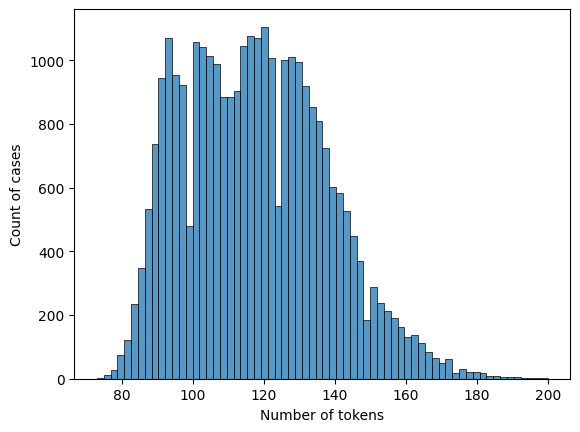

In [17]:
import seaborn as sns
ax = sns.histplot(num_tokens)
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Count of cases")

Text(0, 0.5, 'Count of cases')

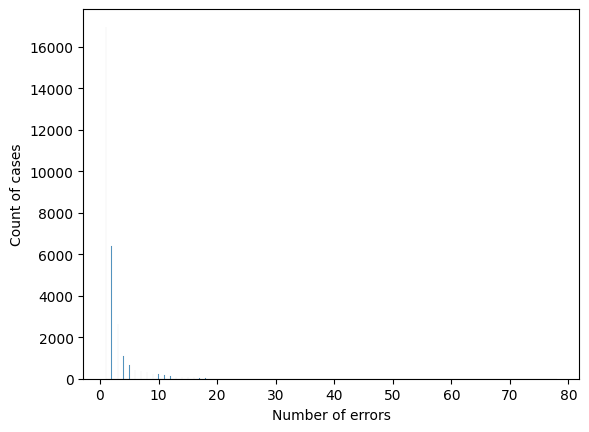

In [18]:
# distribution of number of compile errors
errorcounts = [b.errorcount for b in train]
ax = sns.histplot(errorcounts)
ax.set_xlabel("Number of errors")
ax.set_ylabel("Count of cases")

Text(0, 0.5, 'Number of compilation errors')

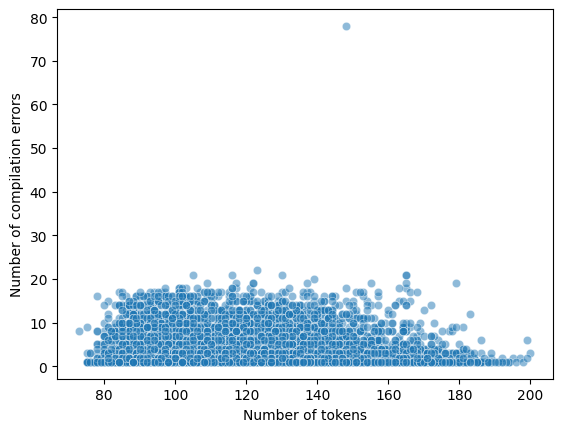

In [19]:
# Relationship between length and errors
ax = sns.scatterplot(x=num_tokens, y=errorcounts, alpha=0.5)
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Number of compilation errors")

Below we show a couple of examples of the types of noise we introduced. In the first example, the buggy program has a typo (`inlude` instead of `include`)
which results in an unknown preprocessor directive. In the second example, the buggy program also has a typo (`nr` instead of `n`), however, in this case
the error that results is an undeclared variable (`n` was a function parameter, but `nr` is nowhere to be found).

In [23]:
# sample of k compile errors in training split
k = 2
sampled = train[:k]
for i, case in enumerate(sampled):
    print("Sample", i)
    print(case.source)
    print("Error:", case.error)
    print("--------------")

Sample 0
#inlude <stdio.h>
#include <stdlib.h>
float catalan(int n,int k){
    if(n>=0){
    if(n==1||n==0) return 1.0;
    else return catalan(n-1,k)*((k+n)*1.0/n);
    }
}
int main() {
	int s;
	scanf("%d",&s);
	printf("%.0f",catalan(s,s));
	return 0;
}
Error: /tmp/tmp0d7_3i32.c:1:2: error: invalid preprocessing directive #inlude; did you mean #include?
    1 | #inlude <stdio.h>
      |  ^~~~~~
      |  include

--------------
Sample 1
#include<stdio.h>
int catalan(int n)
{
    if(nr=0)
    return 1;
    else
    return (2*(2*n+1))/(n+2)*catalan(n-1);
}
int main(){
    int i,n,p;
    for(i=0;i<=5;i++)
    {
        p=catalan(i);
        printf("%d\n",p);
    }
return 0;
}
Error: /tmp/tmpwojypszq.c: In function ‘catalan’:
/tmp/tmpwojypszq.c:4:8: error: ‘nr’ undeclared (first use in this function); did you mean ‘n’?
    4 |     if(nr=0)
      |        ^~
      |        n
/tmp/tmpwojypszq.c:4:8: note: each undeclared identifier is reported only once for each function it appears in

-----

In [21]:
# random sample of k compile errors in test split
test = utils.get_test_data()
k = 2
sampled = test[:k]
for i, case in enumerate(sampled):
    print("Sample", i)
    print(case.source)
    print("Error:", case.error)
    print("--------------")

Sample 0
#include <stdio.h>

int main() 
{                          // starting of program
int m,n;                  //n is the number to be checked
int i;
int count=0;
scanf ("%d %d",m,n);//taking input


for (i=2;i<m;i=i+1)
{if (m%i==0)
count =count+1;
else 
count=count+0;
}


if (count==n)
printf ("YES\n");
else 
printf ("NO\n");

return 0;
}
 
    
    return 0;
}
Error: 28:5: error: expected identifier or ‘(’ before ‘return’
     return 0;
     ^
29:1: error: expected identifier or ‘(’ before ‘}’ token
 }
 ^
--------------
Sample 1
#include <stdio.h>
#include <stdlib.h>
int catalan(int (n+1))
{
  if(n+1==0) return 1;
  else return 2*(2*n+1)/n+2*catalan(n)
}
int main()
{
	int t;
	int k[100];
	scanf("%d\n",&t);
	for(i=0;i<t;i++)
	{
	    scanf("%d\n"&k[i]);   
	}
		for(i=0;i<t;i++)
	{
	    printf("%d\n"catalan(k[i]));   
	}
	return 0;
}
Error: 3:19: error: expected ‘)’ before ‘+’ token
 int catalan(int (n+1))
                   ^
In function ‘main’:
13:6: error: ‘i’ undeclared (first

## Metrics

In our problem statement, we defined two important components: a language oracle $O$ that judges the well-formednes of a program, and $D$ our distance function. We'll look at these in turn. And we'll use the two toy programs below to illustrate. `bad_simple` is ill-formed as it is missing the closing parenthesis in the function parameter list. `ok_simple` is a well-formed program.

In [44]:
bad_simple = """
int main( 
{
    return 0;
}
"""
ok_simple = """"
int main() 
{
    return 0;
}""" 

You can use our `utils` to run the oracle (i.e. `gcc` with the flags described) and get back a `CompileResult`. If the program is well-formed, then the `.ok` member should be `True`, `.errorcount` should be `0`, and `.error` should be `None`. If the program is ill-formed, then you should observe opposite.

In [26]:
utils.gcc_compile(bad_simple)

CompileResult(ok=False, error='/tmp/tmpe_vt23et.c:1:11: error: expected declaration specifiers or ‘...’ before ‘{’ token\n    1 | int main( {return 0;}\n      |           ^\n', errorcount=1)

In [27]:
utils.gcc_compile(ok_simple)

CompileResult(ok=True, error=None, errorcount=0)

Our problem statement introduces a distance function $D$ and a threshold $\delta$. This is quite common in this area, particularly when we don't have user solutions to a problem. The core idea is we want to make sure that the derived program is not too *far* from the original, otherwise we can produce trivial fixes (e.g. remove entire function containing bug). Very often $D$ is defined to be some form of edit distance, and a popular choice is the edit distance over sequence of lexer tokens rather than strings -- ultimately the choice depends on your use-case (e.g. should a typo that requires two key-strokes count more than a typo that requires 1 key-stroke?).

In our `utils` you can use `token_edit_distance` to compute a version of this distance function that also ignores white-space (in most cases).

In [28]:
# typically: satisfy oracle (i.e. compiler) but also need to limit edit distance (e.g. deleting everything yields compilable unit)
# token edit distance: standard levenshtein distance but on lexer outputs (better than simple string distance)
utils.token_edit_distance(
    bad_simple,
    ok_simple
)

1.0

While we won't use it, `utils` also includes a `tree_edit_distance` function. This distance function may more accurately reflect structural changes such as swapping statements, while the same change might be "overinflated" in a "flat" distance function like token edit distance.

In [29]:
# can also use tree edit distance with parse tree that maintains syntax errors
utils.tree_edit_distance(
    bad_simple,
    ok_simple
)

1.0

In this case, both distance functions result in the same edit distance. But it's good to think about example where this is not the case.

* **Extension task**: Find/create some examples where `utils.token_edit_distance` and `utils.tree_edit_distance` result in different values. What use-case can you envision for each?

## Running benchmarks

We've created some utilities for you to be able to run benchmarks easily and get summarized results. `utils.run_benchmark` will run the full benchmark for you. You simply need to provide an instance of a `BenchmarkRunner` class that has a `run_benchmark` method.

In [33]:
show_code(utils.run_benchmark)

def run_benchmark(system: BenchmarkRunner, **kwargs):
    test_data = get_test_data()
    predicted = system.run_benchmark(test_data, **kwargs)
    buggy = [t.source for t in test_data]
    annot = run_basic_annotation(predicted, buggy)
    summary = basic_results_table(annot)
    return summary, annot

The `BenchmarkRunner` works a list of benchmarks, each of which is represented as a `RepairTaskRecord`. For simplicity, we use the same class for both training and test data, for the latter the `target` program is `None`.

In [35]:
train[0]

RepairTaskRecord(code_id='prog30819', user_id='user060', problem_id='prob376', source='#inlude <stdio.h>\n#include <stdlib.h>\nfloat catalan(int n,int k){\n    if(n>=0){\n    if(n==1||n==0) return 1.0;\n    else return catalan(n-1,k)*((k+n)*1.0/n);\n    }\n}\nint main() {\n\tint s;\n\tscanf("%d",&s);\n\tprintf("%.0f",catalan(s,s));\n\treturn 0;\n}', error='/tmp/tmp0d7_3i32.c:1:2: error: invalid preprocessing directive #inlude; did you mean #include?\n    1 | #inlude <stdio.h>\n      |  ^~~~~~\n      |  include\n', errorcount=1, target='#include <stdio.h>\n#include <stdlib.h>\nfloat catalan(int n,int k){\n    if(n>=0){\n    if(n==1||n==0) return 1.0;\n    else return catalan(n-1,k)*((k+n)*1.0/n);\n    }\n}\nint main() {\n\tint s;\n\tscanf("%d",&s);\n\tprintf("%.0f",catalan(s,s));\n\treturn 0;\n}')

To illustrate how you can make your own `BenchmarkRunner` class, here is a toy class that just returns the same (well-formed) canned program every time.

In [36]:
# Dummy run
from typing import List
from repair.utils import BenchmarkRunner, RepairTaskRecord
class JoseBadRepair(utils.BenchmarkRunner):
    def run_benchmark(self, cases: List[RepairTaskRecord]):
        # single dummy repair for each case
        return [["int main(){return 0;}"]] * len(cases)

In [37]:
result = utils.run_benchmark(JoseBadRepair())

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


The `result` is a tuple, where the first element is a summary table, and the second is a list of lists, where each list is an annotated prediction (`PredictionAnnotation`). We'll look at these in turn.

The table has two rows, one which just checks the fraction of benchmarks for which we produced a prediction that compiled (i.e. passed $O$), and the other row checks the fraction that also satisfied our distance threshold (i.e. $D(P, P') \le \delta$). As is often done in this research area, we consider the predictions at different cutoffs (top -1, -3, and -5). Most research stops at top-5 as it is unlikely that users would ever consider more candidates if presented with repair results interactively -- other scenarios (e.g. where you may feed repair into a different system) may consider other cutoffs.

As expected, our toy class has 100% for the compilability goal, but fails in every case once we consider the distance.

In [38]:
result[0]

,stat,top-1,top-3,top-5
0,compile,1.0,1.0,1.0
1,compile+distance,0.0,0.0,0.0


Below we have an instance of a `PredictionAnnotation`, which is just convenience class to combine the original buggy program, our prediction, the compiler, and distance results. Prediction annotations are grouped (as a list) for each benchmark task, since some methods may return multiple predictions.

In [39]:
result[1][0][0]

PredictionAnnotation(prediction='int main(){return 0;}', buggy='#include <stdio.h>\n\nint main() \n{                          // starting of program\nint m,n;                  //n is the number to be checked\nint i;\nint count=0;\nscanf ("%d %d",m,n);//taking input\n\n\nfor (i=2;i<m;i=i+1)\n{if (m%i==0)\ncount =count+1;\nelse \ncount=count+0;\n}\n\n\nif (count==n)\nprintf ("YES\\n");\nelse \nprintf ("NO\\n");\n\nreturn 0;\n}\n \n    \n    return 0;\n}', compile_result=CompileResult(ok=True, error=None, errorcount=0), distance=99.0)

You can view a line-level diff (using `*nix`'s `diff`) between the buggy and predicted program using `utils.diff`.

In [46]:
annot = result[1][0][0]
print(utils.diff(annot.buggy, annot.prediction))

@@ -1,29 +1 @@
-#include <stdio.h>
-
-int main() 
-{                          // starting of program
-int m,n;                  //n is the number to be checked
-int i;
-int count=0;
-scanf ("%d %d",m,n);//taking input
-
-
-for (i=2;i<m;i=i+1)
-{if (m%i==0)
-count =count+1;
-else 
-count=count+0;
-}
-
-
-if (count==n)
-printf ("YES\n");
-else 
-printf ("NO\n");
-
-return 0;
-}
- 
-    
-    return 0;
-}
\ No newline at end of file
+int main(){return 0;}
\ No newline at end of file



As mentioned before, in this case the program completely changes, so the diff is not that interesting, but consider the same setup with our simple toy examples

In [47]:
print(utils.diff(bad_simple, ok_simple))

@@ -1,5 +1,5 @@
-
-int main( 
+"
+int main() 
 {
     return 0;
-}
+}
\ No newline at end of file



## Repairing compile errors with CodeT5

### CodeT5 Overview

[TODO]

### Zero-shot repair with CodeT5

We can carry out repair using the pretrained version of CodeT5 by framing it repair as a cloze-style task (https://arxiv.org/pdf/2207.08281.pdf). A cloze-style task answers a question (fill-in-the-blank style) based on the context. The paper referenced provides a variety of different masking strategies that they use to then fill in predictions with CodeBert. In our case, we perform a single (simple) masking strategy: we mask the entire buggy line (as reported by the compiler) and we replace it with a single mask token (`extra_id_<k>`). We don't need multiple mask tokens per line, as CodeT5 can generate multiple tokens per mask. 

After we have masked-out the buggy lines, we can run CodeT5 on the input, collect the values predicted for each mask token, and replace them in the original buggy program.

In [153]:
from repair.engines import codet5

In [154]:
show_code(codet5.CodeT5ClozeRepair)

class CodeT5ClozeRepair(BaseCodeT5Repair):
    """
    https://arxiv.org/pdf/2207.08281.pdf
    """

    def __init__(self, model_version=None):
        self.model_version = DEFAULT_CODET5_VERSION if model_version is None else model_version
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_version)
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_version)
        self.model = self.model.to(get_torch_device())
        self.model.eval()

    def _localize_line(self, code):
        result = gcc_compile(code)
        if result.ok:
            raise Exception("To localize must have compile error")

        line_regex = re.compile(".c:([0-9]+):[0-9]+: error:")
        matches = line_regex.findall(result.error)
        # turn to 0-indexed
        line_nums = set(int(m) - 1 for m in matches)
        if len(line_nums) == 0:
            # default to first line
            # FIXME: better fall back
            return [0]
        return line_nums

    def _add_code_masks(self, code):
        # FIXME: extend to not mask whole line
        # but just range indicated by error message
        line_nums = self._localize_line(code)
        lines = code.split("\n")
        mask_tokens = []
        for ix, l_ix in enumerate(line_nums):
            mask_token = f"<extra_id_{ix}>"
            lines[l_ix] = mask_token  #+ ";"
            mask_tokens.append(mask_token)
        return ["\n".join(lines), mask_tokens]

    def _decoded_to_mask_tokens_map(self, decoded: str,
                                    mask_tokens: List[str]):
        mapping = {}
        for mask_token in mask_tokens:
            start_ix = decoded.find(mask_token)
            # offset by length of mask itself
            start_ix += len(mask_token)
            end_ix = decoded[start_ix:].find("<extra_id_")
            if end_ix >= 0:
                mask_value = decoded[start_ix:(start_ix + end_ix)]
            else:
                # rest of string
                mask_value = decoded[start_ix:]
            # remove any special tokens
            special_tokens = [
                self.tokenizer.eos_token, self.tokenizer.pad_token
            ]
            for special_tok in special_tokens:
                mask_value = mask_value.replace(special_tok, "")
            mapping[mask_token] = mask_value
        return mapping

    def _fill_code_cloze(self, code: str, mask_token_map: Dict[str, str]):
        for token_name, token_value in mask_token_map.items():
            code = code.replace(token_name, token_value)
        return code

    def repair(self, code: Union[str, List[str]], **kwargs):
        single_program = False
        if isinstance(code, str):
            str_inputs = [code]
            single_program = True
        else:
            assert isinstance(code, list) and isinstance(code[0], str)
            str_inputs = code

        # Replace entire line that has error
        # extract line from errormessage
        batched_mask_tokens = []
        batched_masked_code = []

        for code in str_inputs:
            new_code, mask_tokens = self._add_code_masks(code)
            batched_masked_code.append(new_code)
            batched_mask_tokens.append(mask_tokens)

        num_inputs = len(str_inputs)

        # run as batch with codet5
        encoded_inputs = self.tokenizer(
            batched_masked_code,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
        ).to(get_torch_device())

        # FIXME: set max length to be some reasonable value based on average length of masked line
        max_length = int(
            20 * np.ceil(np.mean([len(ts) for ts in batched_mask_tokens])))
        with torch.no_grad():
            generated = self.model.generate(
                **encoded_inputs,
                max_length=kwargs.get("max_length", max_length),
                num_beams=kwargs.get("num_beams", 3),
                # default to as many as beam size
               

We'll run a version of this approach using the base (200M parameter) model.

In [155]:
cloze_t5 = codet5.CodeT5ClozeRepair("Salesforce/codet5-base")

In [156]:
c5_cloze_res = utils.run_benchmark(cloze_t5, verbose=True)
print(c5_cloze_res[0])

100%|██████████| 100/100 [00:27<00:00,  3.69it/s]

               stat  top-1  top-3  top-5
0           compile   0.36   0.41   0.41
1  compile+distance   0.14   0.19   0.19


And here is an example of what some of these successful repairs look like

In [90]:
ex = [pred for task in c5_cloze_res[1] for pred in task if pred.compile_result.ok and pred.distance < utils.MAX_TOKEN_EDIT_DISTANCE][0]
print(utils.diff(ex.buggy, ex.prediction))

@@ -10,7 +10,7 @@
         for(j=(b-(n-1)*2);j<=b;j=j+2)
         m=m+1;
         if(m>9){
-            m=m%10
+m=9;
         }
     }
 	return 0;



In this, and other cases, we'll see that while the model satisfied our two constraints (compiler and distance), the new generated code line does not necessarily relate to the prior. This is a direct result of our simplistic masking strategy (we mask the whole buggy line). As an extension, consider masking just the suffix of the line from the error location reported by the compiler onwards. Are the results better? Another idea is to comment out the buggy line and place the mask as a prefix,  does that work?

* **Extension Task**: Implement a better masking strategy for the cloze-repair task. You can take inspiration from the strategies implemented in the paper referenced at the start of this section

Like other popular open source language models, there are different variants of CodeT5 based on the number of parameters. We used `codet5-base` previously, which has 220M parameters. Now we will try the same set of benchmarks with `codet5-small`, which has 60M parameters and see what the performance difference is.

In [157]:
## smaller model
cloze_t5_small = codet5.CodeT5ClozeRepair("Salesforce/codet5-small")
c5_cloze_small_res = utils.run_benchmark(cloze_t5_small, verbose=True)
print(c5_cloze_small_res[0])

100%|██████████| 100/100 [00:22<00:00,  4.38it/s]

               stat  top-1  top-3  top-5
0           compile   0.29   0.40   0.40
1  compile+distance   0.07   0.12   0.12


As expected, there is a drop in performance across both metrics and all cut-offs, though the largest drop appears to be in the compile+distance metric.

### Fine-Tuned repair with CodeT5

We have been using the pretrained version of CodeT5 and framed repair as cloze task. Now we'll instead fine-tune CodeT5 with our training data of buggy/fixed (i.e. original well-formed) programs.
Below is a very basic method to finetune the CodeT5. Note that we aren't stopping based on a validation set, we'll just train for a fixed number of epochs. This code is a slight simplification of the original `CodeT5` finetuning scripts. In the interest of time/resources, we'll finetune the smaller model size.

In [158]:
show_code(codet5.CodeT5FineTunedRepair.finetune)

def finetune(
        self,
        train_data=None,
        num_epochs=4,
        batch_size=8,
        n_gpu=1,
        weight_decay=0.0,
        learning_rate=5e-5,
        adam_epsilon=1e-8,
        warmup_steps=5,
        gradient_accumulation_steps=1,
        log_dir=None,
        checkpoint_path=None,
    ):
        # this is a simplified version OF https://github.com/salesforce/CodeT5/blob/main/run_gen.py
        # FIXME: add in validation and save best checkpoint rather than take last
        t0 = time.time()

        self.model.train()

        if n_gpu > 1:
            # for DataParallel
            model = torch.nn.DataParallel(model)

        tb_writer = None
        if log_dir is not None:
            tb_writer = SummaryWriter(log_dir)

        # Prepare training data loader
        if train_data is None:
            train_data = get_train_data()
        train_dataset = _load_labeled_dataset_tokenized(
            train_data,
            self.tokenizer,
            task_prefix=self.task_prefix,
        )
        train_sampler = RandomSampler(train_dataset)
        train_dataloader = DataLoader(train_dataset,
                                      sampler=train_sampler,
                                      batch_size=4,
                                      pin_memory=False)

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [{
            'params': [
                p for n, p in self.model.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            'weight_decay':
            weight_decay
        }, {
            'params': [
                p for n, p in self.model.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            'weight_decay':
            0.0
        }]

        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=learning_rate,
                          eps=adam_epsilon)
        num_train_optimization_steps = num_epochs * len(train_dataloader)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=num_train_optimization_steps)

        # Start training
        train_example_num = len(train_data)
        print("***** Running training *****")
        print(f"  Num examples = {train_example_num}")
        print(f"  Batch size = {batch_size}")
        print(f"  Batch num = {np.ceil(train_example_num / batch_size)}")
        print(f"  Num epoch = {num_epochs}")

        global_step = 0
        for cur_epoch in range(0, num_epochs):
            bar = tqdm.tqdm(train_dataloader,
                            total=len(train_dataloader),
                            desc="Training")
            nb_tr_examples, nb_tr_steps, tr_loss = 0, 0, 0
            self.model.train()

            for step, batch in enumerate(bar):
                batch = tuple(t.to(get_torch_device()) for t in batch)
                source_ids, target_ids = batch
                source_mask = source_ids.ne(self.tokenizer.pad_token_id)
                target_mask = target_ids.ne(self.tokenizer.pad_token_id)

                outputs = self.model(input_ids=source_ids,
                                     attention_mask=source_mask,
                                     labels=target_ids,
                                     decoder_attention_mask=target_mask)
                loss = outputs.loss

                if n_gpu > 1:
                    loss = loss.mean()  # mean() to average on multi-gpu.

                global_step += 1
                if tb_writer is not None:
                    tb_writer.add_scalar('batch_loss', loss.item(), global_step)

                if gradient_accumulation_steps > 1:
                    loss = loss / gradient_accumulation_steps
                tr_loss += loss.item()

                nb_tr_examples += source_ids

One important thing to note is that for our finetuning task, we'll augment our input slightly by prepend the prefix `"FIX C: "`. The idea is that when we use this at inference time, we can prepend the same leading text so that it's clear we are trying to perform the task we fine-tuned for, rather than other tasks. This is a common approach -- the original T5 paper [CITE] uses this to perform multi-task learning, as shown in diagram below. [TODO]

In [ ]:
c5_finetuned = codet5.CodeT5FineTunedRepair()
checkpoint_path = "resources/c5.finetuned.bin"
# change to True to actually run finetuning -- this will take a while, so don't do it during the tutorial (try it afterwards or reduce training
# data and epochs to give it a run)
RUN_FINETUNE = False
if RUN_FINETUNE:
    c5_finetuned.finetune(
        train,
        batch_size=8,
        num_epochs=4,
        checkpoint_path=checkpoint_path,
        log_dir="logs/"
    )
else:
    # load up the model we have finetuned in advance
    c5_finetuned = codet5.CodeT5FineTunedRepair(checkpoint_path)

In [ ]:
c5_finetuned_res = utils.run_benchmark(c5_finetuned, verbose=True, num_beams=3)
c5_finetuned_res[0]

* **Extension task:** Continue fine-tuning from the latest checkpoint, see if performance improves
* **Extension task:** Fine-tune a version with data augmented with examples produced by your new noise operators (see data section previously)

In general, given a collection of repair systems, it can be helpful to see what benchmark tasks all systems solve, what tasks each system individually solved, and then the union of all solutions. It is very often the case that different approaches are complementary and you can get better performance by combining them (if you have an oracle, like we do, you could always check if a task has been solved by a particular system before trying the next one).

You can use the `utils.compare_results` to get a report of these comparisons. It takes a dictionary, where each entry is a system name and the value is the annotated predictions (second element in the result tuple of `utils.run_benchmark`).

In [164]:
# we'll just check the compilation outcome for top prediction, forgetting about distance for now
c5_comparison = utils.compare_results({
    "c5-cloze-base": c5_cloze_res[1], 
    "c5-cloze-small": c5_cloze_small_res[1],
    # "c5-finetune": c5_finetuned_res[1],
}, top_k=1, criteria=lambda p: p.compile_result.ok)
# and summarize as counts
{k:len(v) for k, v in c5_comparison.items()}

{'c5-cloze-base': 36,
 'c5-cloze-small': 29,
 'intersection': 21,
 'union': 44,
 'c5-cloze-base-exclusive': 15,
 'c5-cloze-small-exclusive': 8}

## Parser Error Recovery: GRMTOOLS


In this section we'll switch gears completely and explore a purely symbolic approach to repair the programs in our benchmark. Specifically, we'll take a parser that implements a state-of-the-art parser error recovery mechanism, as described in [TODO], feed in our buggy programs, and then take its edit sequences and apply them to produce a derived (and hopefully fixed) program. We'll start out by covering some basic background on the topic.

### Grammars and parser generators

GRMTOOLs is a whole library for parsing implemented in Rust. If you're not familiar with parsing, the topic is quite broad (and still an active area of research), but we'll do a brief recap for what's needed here.

First, the syntax of a programming language can typically be described using a context-free grammar (CFG). A good reference for this topic can be found here [TODO]. The core idea is the CFG describes the strings that belong to our language (i.e. is this a string a syntactically valid C program). Not every property of a well-formed program can be captured by a CFG, for example, type correctness is not typically something you would be able to express in a CFG since it typically requires a lot more context. 

A CFG consists of a starting symbol, a set of *non-terminal* symbols, a set of *terminal* symbols, and a set of rules that expand a non terminal symbol into zero or more terminal/non-terminal symbols. A string is in the language described the CFG if you can *derive* it by applying the rules beginning from the starting symbol.

We've prepared a (very simplified) grammar that should capture a lot of the subset of C that we care about for this tutorial (but not all -- more on this later). Here is a quick subset. `program` is our starting symbol. Lower case terms are non-terminals, and upper case quoted strings are our terminals. 

In [7]:
with open("resources/mini-c99.y") as fin:
    print("\n".join(fin.read().splitlines()[36:55]))

%%

program : declaration_list;


declaration_list: declaration_or_def declaration_list | declaration_or_def;


declaration_or_def: 
    function_def
    | var_declaration
    | assigns "SEMICOLON"
    ;


function_def:
    type "ID" "LEFT_PAREN" parameter_list "RIGHT_PAREN" statement
    |  "ID" "LEFT_PAREN" parameter_list "RIGHT_PAREN" statement
;


These terminals in turn are defined in a separate file, which describes each terminal symbol using a regular expression. When parsing, the initial string is transformed into a stream of tokens (i.e. terminals) by a *lexer*, which are then processed based on the grammar rules.

In [9]:
with open("resources/mini-c99.l") as fin:
    print("\n".join(fin.read().splitlines()[:10]))


%%
int   "INT"
void   "VOID"
char   "CHAR"
float  "FLOAT"
double "DOUBLE"
if     "IF"
else   "ELSE"
while  "WHILE"


GRMTOOLs has a *parser generator*, which takes our lexer definitions (`.l`) and our grammar definition (`.y`), and generates a module that can parse strings accordingly. In some parser generators, such as `bison` you can define actions associated with each parsing rule (e.g. to build up your AST). However, GRMTOOLs does not support this, and there are a few other differences. See [TODO] for list of the differences between GRMTOOLs `.y` and `.l` files and those typically used in other tools.

We'll use `nimbleparse`, part of the GRMTOOLs tool-kit, which takes our two definition files and program file and produces a derivation (i.e. the application of rules used to parse it) if it satisfies the grammar, and otherwise (if it can find one) a sequence of one or more edits that can be made to satisfy the grammar.

### Parser recovery for repairing our tasks
We'll use `nimbleparse` to attempt to fix our programs. In contrast to other approaches, this will only fix syntax mistakes -- so other error like undefined variables will persist. However, it is still helpful to understand this approach since 1) syntax errors are quite common in some settings (e.g. intro programming), 2) syntactically repaired programs can be an input for another downstream repair tool.

One important difference between traditional parsing and our use of this tool for repair is that our grammar does not actually cover *all* of C. As a result, syntactically valid C programs may actually be rejected (and some syntactically invalid programs may actually be captured in our grammar). This is a deliberate choice: it is often easy to write a core of the grammar you want to cover but covering all programs may require more engineering effort. Furthermore, the more complex your grammar is, the more work the recovery mechanism may need to do to produce edit candidates -- this can be detrimental in cases where you want to produce repairs online. In general, a productive approach is to define small portion of your grammar, make sure it covers most well-formed programs you are interested in, and can fix common mistakes in the ill-formed programs.

Let's validate that our grammar covers a substantial portion of the well-formed programs we want to work with. We'll take the first 200 training examples and apply `nimbleparse` to the well-formed program. If no stderr message is produced, the program satisfies our parser.

In [18]:
from repair.engines import grmtools
parsed = [grmtools._run_nimbleparse(task.target) for task in tqdm.tqdm(train[:200])]
no_error = [len(p.strip()) == 0 for p in parsed]
print("Parsed with our approx grammar:", sum(no_error) / len(parsed))

100%|██████████| 200/200 [00:12<00:00, 15.42it/s]

Parsed with our approx grammar: 0.765


* **Extension task**: Extend the `.l` and `.y` files (or even rewrite them) to cover more of the student's well-formed programs. As you change these, consider re-running the benchmark and seeing if these changes lead to more/less fixes and how long this takes (note that this timing is not reflective of production use of GRMTOOLs, which is super fast, as we are calling `nimbleparse` with `subprocess` and doing a lot of mangling of stderr logs. A production approach would implement the parser directly in `rust` using GRMTOOLs.)

Now we'll go ahead and use this tool to try to repair our student benchmark.

In [19]:
grmt_repair = grmtools.GRMTRepair()

In [22]:
show_code(grmt_repair.repair)

def repair(self, code: str, **kwargs) -> List[Dict[str, Any]]:
        curr_depth = kwargs.get("_curr_depth", 0)
        max_depth = kwargs.get("max_depth", DEFAULT_MAX_DEPTH)

        try:
            logs = _run_nimbleparse(code)
            edit_seqs = _parse_nimbleparse_logs(logs)
            if len(edit_seqs) > 0:
                # note that because locations can change based on
                # repair, it is easier to run nimbleparse multiple
                # times after making the first seq of edits, rather`
                # than try to keep locations consistent throughout
                code = _apply_nimbleparse_edit_seq(code, edit_seqs[0])

            if len(edit_seqs) > 1:
                kwargs = dict(kwargs)
                kwargs["_curr_depth"] = curr_depth + 1
                kwargs["max_depth"] = max_depth
                # call with newly changed code
                return self.repair(code, **kwargs)

            # FIXME: consider applying a C formatter to make code nicer
            return [{"repair": code}]
        except Exception as err:
            if DEBUG:
                import pdb
                pdb.post_mortem()
            return [{"repair": code}]

In [63]:
grmt_res = utils.run_benchmark(grmt_repair, verbose=True)
grmt_res[0]

100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


,stat,top-1,top-3,top-5
0,compile,0.28,0.28,0.28
1,compile+distance,0.27,0.27,0.27


In this case, our approach with `GRMTRepair` yielded fewer fixes, but note that the gap between `compile` and `compile+distance` is (unsurprisingly) much smaller than what we found when applying our cloze-style and fine-tuned repair with CodeT5. One advantage of symbolic approaches is that we have some guarantees -- in this case that whatever we return will satisfy *our* grammar (which in turn should be closely related to the real grammar used by `gcc`) and it is a minimal set of edits to adhere to that grammar. With more engineering effort we could continue to raise this number. For example, we currently produce a single candidate repair (by taking the top edit sequence for each error location), but you could create more diversity by combining suggested edits. GRMTOOLs returns the minimal distance edits for each error location, and locations are dependent.

Let's look at how many tasks we returned a candidate (i.e. a repair that was not just equivalent to the original input buggy program -- which we return as a default if we can't fix anything to facilitate composition with other tools.)

In [64]:
sum([task[0].prediction != task[0].buggy for task in grmt_res[1]]) / len(grmt_res[1])

0.76

While we produce a candidate for 76\% of programs, we notice that the portion that satisfies the compiler is substantially lower, so let's take a look at the set that did not satisfy that check.

In [65]:
grmt_failed = [task[0] for task in grmt_res[1] if task[0].prediction != task[0].buggy and not task[0].compile_result.ok]
len(grmt_failed)

48

It can be quite helpful to see what some of these failures are to understand some of the tradeoffs involved in using `GRMTRepair`. You'll find that many of these errors relate to undeclared variables and other type errors,
which we *know* we can't fix with a syntax-only repair strategy. 

* **Extension Task**: Combine `GRMTRepair` with one of our other repair strategies and see if the overall metrics improve.

In [66]:
i = 1
print(grmt_failed[i].prediction)
print(grmt_failed[i].compile_result.error)

#include <stdio.h>
#include <stdlib.h>
int catalan(int (n))
{
  if(n+1==0) return 1;
  else return 2*(2*n+1)/n+2*catalan(n)
 ; }
int main()
{
	int t;
	int k[100];
	scanf("%d\n",&t);
	for(i=0;i<t;i++)
	{
	    scanf("%d\n"&k[i]);   
	}
		for(i=0;i<t;i++)
	{
	    printf("%d\n" * catalan(k[i]));   
	}
	return 0;
}
/tmp/tmp8946sa_m.c: In function ‘main’:
/tmp/tmp8946sa_m.c:13:6: error: ‘i’ undeclared (first use in this function)
   13 |  for(i=0;i<t;i++)
      |      ^
/tmp/tmp8946sa_m.c:13:6: note: each undeclared identifier is reported only once for each function it appears in



In [67]:
len([fail for fail in grmt_failed if "undeclared" in fail.compile_result.error or "invalid type" in fail.compile_result.error])

34

Remaining failures are due to our approximate grammar, which can also result in edits that are in fact not valid C. How much you invest in refining your grammar depends on your use case.

In [69]:
other_failed = [
    fail for fail in grmt_failed 
    if not("undeclared" in fail.compile_result.error or "invalid type" in fail.compile_result.error)
]

In [81]:
print(other_failed[0].compile_result.error)

/tmp/tmp000lzzf_.c: In function ‘_id’:
/tmp/tmp000lzzf_.c:28:16: error: expected declaration specifiers before ‘return’
   28 |      _id  (  ) return 0;
      |                ^~~~~~
/tmp/tmp000lzzf_.c:28: error: expected ‘{’ at end of input
   28 |      _id  (  ) return 0;
      | 



## Fixing Syntax Errors with Codex

The remainder of this tutorial is optional as it requires an OpenAI key to execute. You can apply for an OpenAI trial account (and upgrade to a paid account afterwards) at [https://openai.com/](https://openai.com/). If you do so, I recommend setting up soft and hard spending limits to avoid overusing the API -- I set mine to about $5, which I am comfortable using.

You should set your API key by exporting it as an environment variable `export OPENAI_API_KEY=<key>` or executing the code below which uses `os.environ` to set the same variable.

However, note that the API does perform rate-limiting, and we have not implemented any rate-limit waiting/retries in the code below, so you won't be able to really run benchmarks. Instead, you should just play around with one-off examples to get a sense of how this would work in practice.

### Codex Overview

As many are probably aware, Codex [CITE] is a large (Davinci=175B parameters) language model that has been trained on both code and natural language. It has been shown to be effective for a wide range of code-related tasks, such as code generation from natural language, code translation between programming languages, program repair, and more.

In the code below, you'll see a quick convenience wrapper around the `openai` API.

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "<key>"

In [84]:
from repair.engines import codex

In [87]:
show_code(codex.CodexEngine)

class CodexEngine(object):

    def __init__(
        self,
        openai_key: str,
        temperature: float = 0,
        n: int = 1,
        maxtokens: int = 200,
        stop: str = "///",
        engine: str = "code-davinci-002",
    ):
        openai.api_key = openai_key
        self.temperature = temperature
        self.maxtokens = maxtokens
        self.n = n
        self.top_p = 1.0
        self.presence_penalty = 0.0
        self.frequency_penalty = 0.0
        self.stop = stop
        self.engine = engine

    def complete(self, prompt: str, **kwargs):
        try:
            response = openai.Completion.create(
                engine=self.engine,
                prompt=prompt,
                max_tokens=kwargs.get("maxtokens", self.maxtokens),
                temperature=kwargs.get("temperature", self.temperature),
                top_p=kwargs.get("top_p", self.top_p),
                presence_penalty=kwargs.get("presence_penalty",
                                            self.presence_penalty),
                frequency_penalty=kwargs.get("frequency_penalty",
                                             self.frequency_penalty),
                stop=kwargs.get("stop", self.stop),
                n=kwargs.get("n", self.n),
                logprobs=1,
            )
            unsorted_completions = [
                (completion["text"],
                 np.mean(completion["logprobs"]["token_logprobs"]))
                for completion in response["choices"]
            ]

            # higher average prob should come first
            sorted_completions = sorted(unsorted_completions,
                                        key=lambda x: x[1],
                                        reverse=True)
            result_dicts = []
            for completion_txt, avg_logprob in sorted_completions:
                result_dicts.append({
                    "completion": completion_txt,
                    "avg_logprob": avg_logprob,
                })
            return result_dicts
        except Exception as e:
            print("Skipping exception")
            print(e)
            return None

### Base Codex: simple prompt and buggy program

The absolute simplest place to start is to provide Codex with a basic prompt that includes the buggy program, an instruction to fix it, and a prefix for the completion that will bias the model towards the task we want to complete.

In [88]:
show_code(codex.CodexBaseRepair)

class CodexBaseRepair(CodexRepair):
    """
    Based on https://beta.openai.com/examples/default-fix-python-bugs
    """

    def __init__(self, *args, **kwargs):
        self.codex = CodexEngine(*args, **kwargs)

    def get_prompt(self, code: str, **kwargs) -> str:
        # Based on https://beta.openai.com/examples/default-fix-python-bugs
        prompt = """//// Fix bugs in the below code\n"""
        prompt += f"/// Buggy C\n{code}\n\n"
        prompt += "/// Fixed C"
        if 'fixed' in kwargs and kwargs['fixed'] is not None:
            prompt += f"\n{kwargs['fixed']}\n\n"

        return prompt

    def get_repair_from_completion_(
            self, completion_dict: Dict[str, Any]) -> Dict[str, Any]:
        comp = completion_dict["completion"]
        # remove first \n and last \n, result from our prompt style
        if comp[0] == "\n":
            comp = comp[1:]
        if comp[-1] == "\n":
            comp = comp[:-1]
        return {"repair": comp, "score": completion_dict["avg_logprob"]}

    def deduplicate_repairs_(
            self, repair_dicts: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        unique_repair_dicts = []
        already_included = set()
        for rd in repair_dicts:
            repair_str = rd["repair"]
            if repair_str not in already_included:
                unique_repair_dicts.append(rd)
                already_included.add(repair_str)
        return unique_repair_dicts

    def repair(self, code: str, **kwargs):
        # FIXME: warn if number of tokens too few for length of code
        # or set to num tokens + K
        # Use: https://github.com/openai/tiktoken , which is fast openai tokenizer
        # to estimate tokens for code and pass in as maxtokens=<val>
        prompt = self.get_prompt(code, **kwargs)
        completion_dicts = self.codex.complete(prompt, **kwargs)
        if completion_dicts is None:
            return []

        repair_dicts = [
            self.get_repair_from_completion_(c) for c in completion_dicts
        ]
        repair_dicts = self.deduplicate_repairs_(repair_dicts)
        return repair_dicts

In [105]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
codex_base = codex.CodexBaseRepair(OPENAI_API_KEY)

We'll run a single query for a task in our benchmark and request a single completion.

In [113]:
codex_base_pred = codex_base.repair(test[1].source, n=1)[0]['repair']

This task had multiple issues: the user incorrectly wrote an addition expression in the function parameter list, they forgot to declare the loop variable `i`, and they missed a comma in a `printf`
call between the format string and the following argument. In fact, note that there is actually also a mistake at the second `scanf` call where the user also forgot a `,`, but the compiler doesn't report this mistake.

In [133]:
print(test[1].source)
print(test[1].error)

#include <stdio.h>
#include <stdlib.h>
int catalan(int (n+1))
{
  if(n+1==0) return 1;
  else return 2*(2*n+1)/n+2*catalan(n)
}
int main()
{
	int t;
	int k[100];
	scanf("%d\n",&t);
	for(i=0;i<t;i++)
	{
	    scanf("%d\n"&k[i]);   
	}
		for(i=0;i<t;i++)
	{
	    printf("%d\n"catalan(k[i]));   
	}
	return 0;
}
3:19: error: expected ‘)’ before ‘+’ token
 int catalan(int (n+1))
                   ^
In function ‘main’:
13:6: error: ‘i’ undeclared (first use in this function)
  for(i=0;i<t;i++)
      ^
13:6: note: each undeclared identifier is reported only once for each function it appears in
19:19: error: expected ‘)’ before ‘catalan’
      printf("%d\n"catalan(k[i]));   
                   ^


We can see that the repair Codex suggests in fact solves these three issues.

In [134]:
print(codex_base_pred)

#include <stdio.h>
#include <stdlib.h>
int catalan(int n)
{
  if(n==0) return 1;
  else return 2*(2*n+1)*catalan(n-1)/(n+2);
}
int main()
{
	int t;
	int k[100];
	scanf("%d\n",&t);
	for(int i=0;i<t;i++)
	{
	    scanf("%d\n",&k[i]);   
	}
		for(int i=0;i<t;i++)
	{
	    printf("%d\n",catalan(k[i]));   
	}
	return 0;
}



In [118]:
utils.gcc_compile(codex_base_pred).ok

True

But if we look at the edit distance for this example, we'll see that it is much larger:

In [132]:
utils.token_edit_distance(test[1].source, codex_base_pred)

20.0

Inspecting the `diff` we'll see that Codex actually made multiple additional changes -- particularly it changed the whole definition of the `catalan` function. The new definition fixes multiple mistakes (the base case)
as well as incorrect order of operations in the recursive case. This behavior, where Codex (and really any language model) makes more changes than desired (for our use case of just compiler error fixes), is just another example of the tradeoff in using neural approaches (no guarantees on generation).

In [131]:
print(utils.diff(test[1].source, codex_base_pred))

@@ -1,22 +1,22 @@
 #include <stdio.h>
 #include <stdlib.h>
-int catalan(int (n+1))
+int catalan(int n)
 {
-  if(n+1==0) return 1;
-  else return 2*(2*n+1)/n+2*catalan(n)
+  if(n==0) return 1;
+  else return 2*(2*n+1)*catalan(n-1)/(n+2);
 }
 int main()
 {
 	int t;
 	int k[100];
 	scanf("%d\n",&t);
-	for(i=0;i<t;i++)
+	for(int i=0;i<t;i++)
 	{
-	    scanf("%d\n"&k[i]);   
+	    scanf("%d\n",&k[i]);   
 	}
-		for(i=0;i<t;i++)
+		for(int i=0;i<t;i++)
 	{
-	    printf("%d\n"catalan(k[i]));   
+	    printf("%d\n",catalan(k[i]));   
 	}
 	return 0;
-}
\ No newline at end of file
+}



* **Extension Task**: Consider modifying the implementation of `codex.CodexBaseRepair` to only feed in the lines that have a compiler-reported error, and do so incrementally.

### Add error message to improve error localization

For more complex mistakes, it may help to actually include error localization explicitly in the prompt provided to Codex.

In [135]:
show_code(codex.CodexWithErrorInfo)

class CodexWithErrorInfo(CodexBaseRepair):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.error_cache = {}

    def _get_error_info(self, code: str) -> str:
        if code not in self.error_cache:
            self.error_cache[code] = gcc_compile(code).error
        return self.error_cache[code]

    def get_prompt(self, code: str, **kwargs):
        prompt = """//// Fix bugs in the below code\n"""
        prompt += f"/// Buggy C\n{code}\n\n"
        error_msg = self._get_error_info(code)
        prompt += f"/// Error Message\n{error_msg}\n\n"
        prompt += "/// Fixed C"
        if 'fixed' in kwargs and kwargs['fixed'] is not None:
            prompt += f"\n{kwargs['fixed']}\n\n"

        return prompt

In this case, we take the error information directly from `gcc`'s error message but you could replace this other approaches to error localization. To read more on this topic see [TODO] for a great guide.

### Adding examples of related repairs
When using a model like Codex, it is common to provide few-shots (examples) of the task to improve performance, as the model was not trained explicitly for our use case. Three simple ways to add few-shots are:

* Fixed: manually curate some common errors and their fixes (particularly useful for less-common languages with a recurring mistakes -- e.g. Excel formulas)
* Random: randomly sample from an example bank (in our case, that can be our training data -- the same point regarding synthetic/telemetry data applies as before)
* Smart: automatically select examples from a bank that have *some* relationship to your current program. We'll explore this point in a bit more detail.

The `CodexWithFewShots` class implements a few-shot prompt by taking examples provided by a `FewShotSelector`.

In [139]:
show_code(codex.CodexWithFewShots)

class CodexWithFewShots(CodexBaseRepair):

    def __init__(self, shot_selector: FewShotSelector, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.shot_selector = shot_selector
        self.prompt_helper = CodexWithErrorInfo(*args, **kwargs)

    def get_prompt(self, code: str, **kwargs):
        few_shots = self.shot_selector.select_shots(code, kwargs.get("k", 3))
        prompt = ""
        for shot in few_shots:
            prompt += self.prompt_helper.get_prompt(shot.source,
                                                    fixed=shot.target)

        prompt += self.prompt_helper.get_prompt(code)
        return prompt

Below are two examples using the fixed and random strategy mentioned previously.

In [140]:
# toy example
example_bank = train[:30]
fixed_shot_selector = codex.FixedFewShots(example_bank)
random_shot_selector = codex.RandomFewShots(example_bank)

We'll focus on the *smart* approach mentioned before. Specifically, we'll retrieve few-shots from our example bank based on the similarity of their error message to our current program's error message. In our case, we'll define the similarity between error messages to be the cosine similarity between their embeddings (produced using CodeBERT).

In [141]:
show_code(codex.SimilarityFewShots)

class SimilarityFewShots(FewShotSelector):

    def __init__(self, example_bank: List[RepairTaskRecord], verbose=False):
        self.example_bank = list(example_bank)
        self.embedder = CodeBertEmbedder()
        if not verbose:
            self.embedded_bank = self._get_norm_embedding([e.source for e in self.example_bank])
        else:
            # WARNING: just for debugging/seeing progress...
            res = [self._get_norm_embedding([e.source]) for e in tqdm.tqdm(self.example_bank)]
            self.embedded_bank = np.vstack(res)

    def _get_norm_embedding(self, programs: List[str]) -> np.ndarray:
        vectors = self.embedder.embed(programs).numpy()
        normed_vectors = vectors / np.linalg.norm(vectors, ord=2, axis=1).reshape(-1, 1)
        return normed_vectors

    def _retrieve_nearest_k_ixs(self, vec: np.ndarray, k: int) -> List[int]:
        # FIXME: replace with a fast approximate search engine like FAISS to scale
        scores = np.matmul(self.embedded_bank, vec.T).flatten()
        top_ixs = np.argsort(scores)[-k:]
        return top_ixs

    def select_shots(self, code: str, k: int) -> List[RepairTaskRecord]:
        vec = self._get_norm_embedding([code])
        ixs = self._retrieve_nearest_k_ixs(vec, k)
        chosen = [self.example_bank[i] for i in ixs]
        return chosen

Below is an overview of the `CodeBert`-based embedder for `gcc` error messages.

In [142]:
from repair import codesimilarity
show_code(codesimilarity.CodeBertEmbedder)

class CodeBertEmbedder(object):

    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained(
            "microsoft/codebert-base")
        self.model = AutoModel.from_pretrained("microsoft/codebert-base")
        self.model = self.model.to(get_torch_device())
        self.model.eval()
        self.cache_compile_results = {}

    def prepare_msg_input(self, msg: str):
        # FIXME: better preparation (e.g. distinguish between NL/code)
        return msg

    def embed_compile_results(self, compile_results: List[CompileResult]):
        """
        following https://github.com/microsoft/CodeBERT
        """
        if isinstance(compile_results, CompileResult):
            compile_results = [compile_results]

        msgs = [r.error for r in compile_results]
        if any(m is None for m in msgs):
            raise Exception("Embedding compiler error message requires error")

        txt_inputs = [self.prepare_msg_input(m) for m in msgs]
        encoded_inputs = self.tokenizer(
            txt_inputs,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
        ).to(get_torch_device())
        with torch.no_grad():
            result = self.model(**encoded_inputs)
        # aggregate with average
        # FIXME: consider other approaches to aggregating or using pooled output
        embeddings = result[0].mean(dim=1)
        return embeddings

    def embed(self, programs: List[str]):
        msgs = []
        for prog in programs:
            if prog not in self.cache_compile_results:
                self.cache_compile_results[prog] = gcc_compile(prog)
            msgs.append(self.cache_compile_results[prog])
        return self.embed_compile_results(msgs)

We embed our example bank ahead of time, so at prediction time we can just embed our current program's error message and retrieve the most similar examples. In practice, you might use a vector-database that supports fast (approximate) nearest neighbors queries. One such example is FAISS [CITE], but there are multiple open source and paid alternatives.

In [143]:
sim_shot_selector = codex.SimilarityFewShots(example_bank, verbose=True)

100%|██████████| 30/30 [00:18<00:00,  1.59it/s]


We can instantiate out `CodexWithFewShots` to use our similarity-based example bank, and as before we'll perform a single repair to demonstrate.

In [149]:
codex_shots = codex.CodexWithFewShots(sim_shot_selector, OPENAI_API_KEY)
codex_shots_res = codex_shots.repair(test[10].source, n=1, temperature=0.0)[0]['repair']
print(codex_shots_res)

#include <stdio.h>
#include <stdlib.h>
int fib(int n){
    if(n==0)
    return 0;
    else if(n==1)
    return 1;
    else
    return (fib(n-1)+fib(n-2));
}
int search(int n,int a[n],int key){
   int i;
   for(i=0;i<n;i++){
       if(a[i]==key)
       return 1;
   }
}
int main() {
    int t;
scanf("%d",&t);
    while(t--){
        int n,key;
        scanf("%d",&n);
        int a[n];
        for(int i=0;i<n;i++){


In [151]:
utils.gcc_compile(codex_shots_res).ok

False

### (Some) Parameters that affect repair with Codex

There are many choices you can make when using Codex that will impact performance. A summary of at least some factors that are typically worth exploring are below. You may want to experiment with these and see if you get different results.

* Temperature: consider varying values and see different performance (higher temperatures can provide more diverse repairs)
* Number of candidates sampled
* Of course, the prompt
* Type of sampling: nucleus sampling vs temperature sampling

### More extension tasks with Codex
While due to the limitation of needing an OpenAI key this tutorial does not spend too much time on Codex, here are some extension task ideas that may be of interest.

* Repair iteratively (if have more than one mistake) [CITE]: JIALU
* Send smaller context around error location (faster and can avoid spurious changes)
* CodeBERT similarity was out-of-the-box, but what if we tune specifically for repair and on our dataset? [CITE]: tst
* Increase the size of the example bank
* Implement better ranking (currently we rank candidates just based on the average token log probabilityes) [CITE] reference Jeevana paper

For a recent paper on using Codex to perform syntax (and some semantic) repairs, see [TODO].

# End

Thank you for joining us for this tutorial. I hope by the end you have now a good sense of some ideas that might be fun to try in this space and how to get started!